# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [3]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [4]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 12s 1us/step


In [5]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer1 = DenseLayer(num_features, n_hidden_1)
    # Другий шар, який складається з 256 нейронів
    self.layer2 = DenseLayer(n_hidden_1, n_hidden_2)
    # Вихідний шар
    self.out_layer = DenseLayer(n_hidden_2, num_classes)

  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x = self.layer1(x, activation=1)
    x = self.layer2(x, activation=1)
    x = self.out_layer(x, activation=1)
    return x


In [6]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    # Порівняємо передбачені мітки зі справжніми мітками
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    # Перетворимо булеві значення на числа та обчислимо середню точність
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


In [7]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  optimizer = tf.optimizers.SGD(learning_rate)

  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

  trainable_variables = neural_net.trainable_variables
  gradients = g.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, accuracy(pred, output_y)


In [8]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    loss, acc = train(neural_net, batch_x, batch_y)

    loss_history.append(loss)
    accuracy_history.append(acc)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        print(f"Step {step}, Loss: {loss}, Accuracy: {acc}")


Step 100, Loss: 586.5208740234375, Accuracy: 0.1640625
Step 200, Loss: 584.7581176757812, Accuracy: 0.15234375
Step 300, Loss: 580.2559814453125, Accuracy: 0.15625
Step 400, Loss: 577.1925659179688, Accuracy: 0.203125
Step 500, Loss: 571.3485717773438, Accuracy: 0.21875
Step 600, Loss: 561.3350219726562, Accuracy: 0.19921875
Step 700, Loss: 531.3195190429688, Accuracy: 0.30859375
Step 800, Loss: 554.5830078125, Accuracy: 0.23828125
Step 900, Loss: 525.2430419921875, Accuracy: 0.2890625
Step 1000, Loss: 504.7279052734375, Accuracy: 0.28125
Step 1100, Loss: 520.4497680664062, Accuracy: 0.25390625
Step 1200, Loss: 507.6868896484375, Accuracy: 0.35546875
Step 1300, Loss: 504.5812683105469, Accuracy: 0.2890625
Step 1400, Loss: 484.7696533203125, Accuracy: 0.36328125
Step 1500, Loss: 471.95068359375, Accuracy: 0.40234375
Step 1600, Loss: 461.96533203125, Accuracy: 0.4140625
Step 1700, Loss: 419.1279602050781, Accuracy: 0.40234375
Step 1800, Loss: 419.9404296875, Accuracy: 0.44140625
Step 190

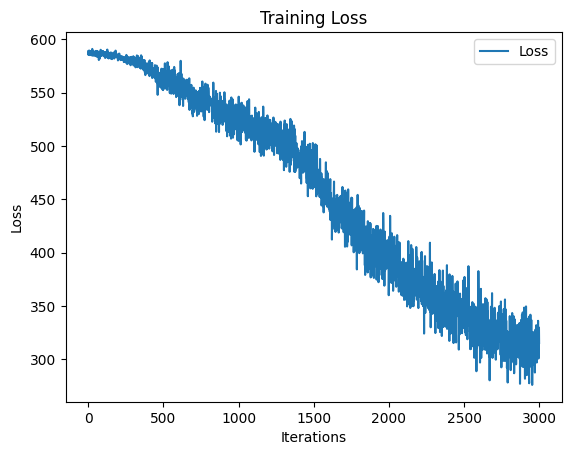

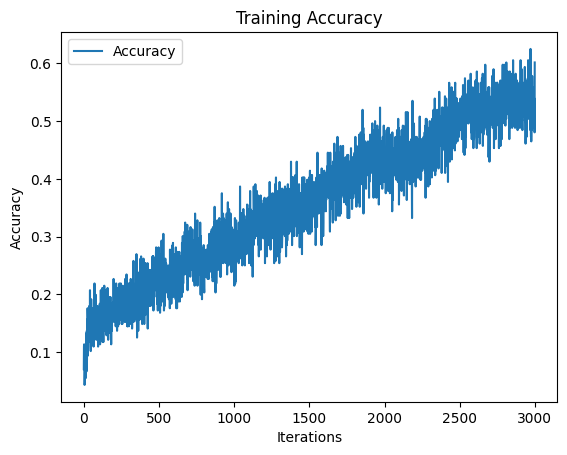

In [9]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

plt.plot(loss_history, label='Loss')
plt.title('Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(accuracy_history, label='Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



In [10]:
def test(neural_net, input_x, output_y):
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)
    acc = accuracy(pred, output_y)
    return loss, acc

test_loss, test_acc = test(neural_net, x_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")


Test Loss: 12065.724609375, Test Accuracy: 0.5375000238418579


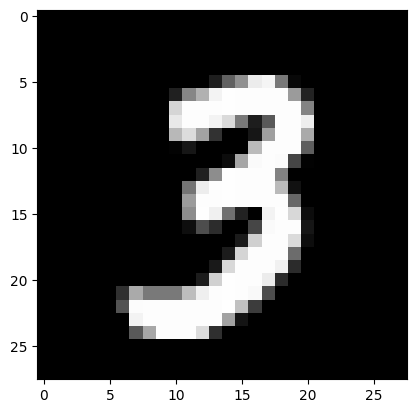

Predicted Label: 3, True Label: 3


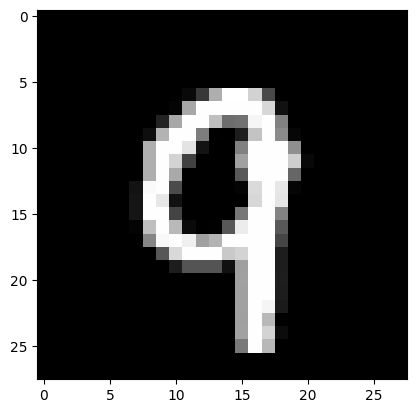

Predicted Label: 7, True Label: 9


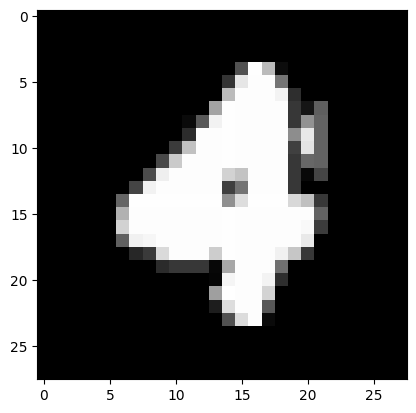

Predicted Label: 7, True Label: 4


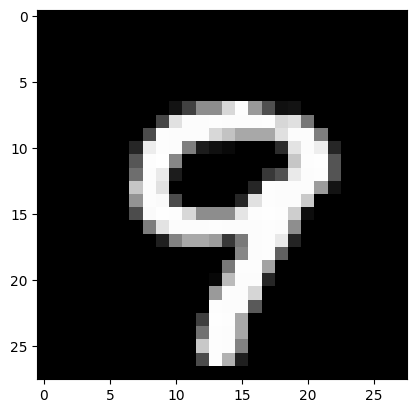

Predicted Label: 7, True Label: 9


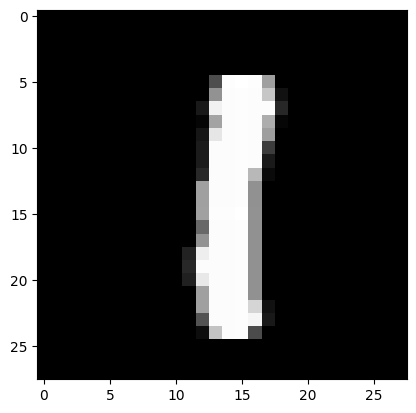

Predicted Label: 1, True Label: 1


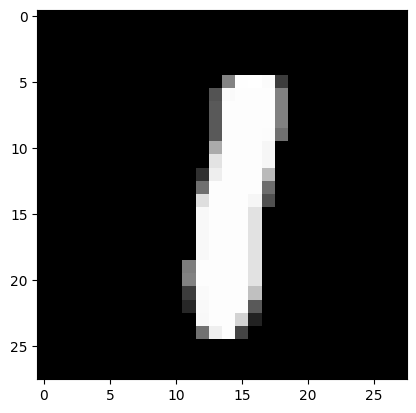

Predicted Label: 1, True Label: 1


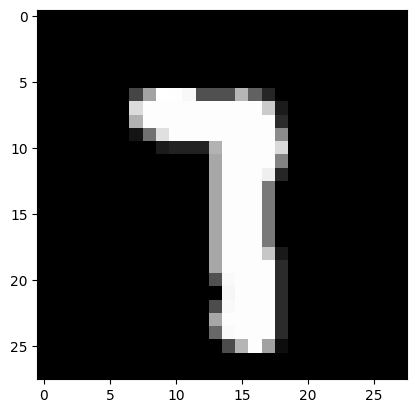

Predicted Label: 7, True Label: 7


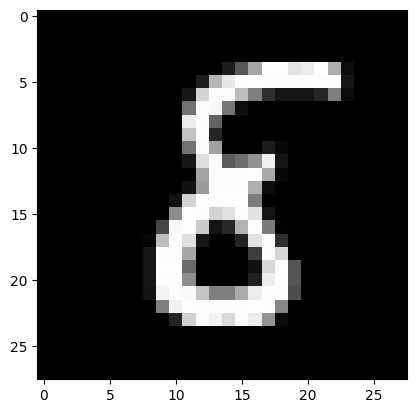

Predicted Label: 1, True Label: 8


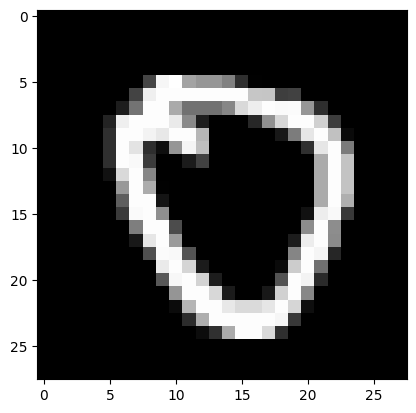

Predicted Label: 3, True Label: 0


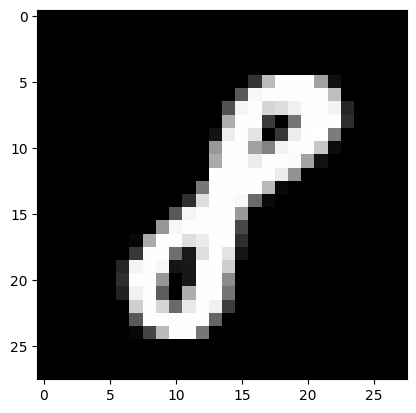

Predicted Label: 3, True Label: 8


In [12]:
random_indices = random.sample(range(len(x_test)), 10)

for idx in random_indices:
    image = x_test[idx].reshape((28, 28))
    plt.imshow(image, cmap='gray')
    plt.show()
    prediction = np.argmax(neural_net(x_test[idx:idx+1]))
    print(f"Predicted Label: {prediction}, True Label: {y_test[idx]}")



